
### [**Importing libraries and loading data**](#section-load)

### [**Helper Functions**](#section-helper)

### [**Data Cleaning and Preprocessing**](#section-cleaning)
    
### [**Feature Engineering and ML**](#section-features)

### [**Explanations with SHAP values**](#section-explain)

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
df = pd.read_csv('/kaggle/input/stack-overflow-annual-developer-survey-2022/survey_results_public.csv')
print(df.shape)

(73268, 79)


# Helper Functions
<a id="section-helper" ></a>

In [2]:
# wrapper to run train, test and evaluate 
def train_test_eval(estimator, X=None, y=None, metric=None, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    estimator.fit(X_train, y_train)
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    train_err = metric(y_train_pred, y_train)
    test_err = metric(y_test_pred, y_test, **kwargs.get('metric_args', None))
#     print(f'train_err: {train_err}, test_err: {test_err}')
    return train_err, test_err


# Wrapper to encode all the object-typed df[col] into one-hot-encoded columns
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], prefix=[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

<a id="section-cleaning"></a>
# Cleaning and Preprocessing data

- Handle nulls
- Rename columns
- Convert categorical to one-hot encoding
- Handle outliers

In [3]:
df = df[~df['DevType'].fillna('none').str.contains(';')]
df = df.dropna(subset=['DevType', 'ConvertedCompYearly'],axis=0)
df.sample(5).T


cols2drop = ['ResponseId', 'Currency', 'CompTotal', 'CompFreq', 'NEWSOSites', 'Trans', 'Sexuality', 'Ethnicity', 'Accessibility', 'MentalHealth', 
             'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Frequency_1',
             'Frequency_2', 'Frequency_3', 'TrueFalse_1', 'TrueFalse_2', 'TrueFalse_3', 'PurchaseInfluence', 'BuyNewTool', 
             'LanguageWantToWorkWith', 'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 
             'WebframeWantToWorkWith', 'MiscTechWantToWorkWith', 'ToolsTechWantToWorkWith',
             'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use', 'VersionControlSystem',
             'VCInteraction', 'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncWantToWorkWith', 'Blockchain', 
             'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'TimeSearching', 'TimeAnswering', 
             'Onboarding', 'ProfessionalTech', 'SurveyLength', 'SurveyEase']
df = df.drop(cols2drop, axis=1)
print(df.shape)
# Convert compensations into kUSD/year
df['ConvertedCompYearly'] = round(df['ConvertedCompYearly']*1e-3,1)
print(df.shape)
# Exclude columns with non-unique values
df = df[df.columns[df.nunique() > 1]]

#df = df[df['DevType']=='Data scientist or machine learning specialist']
df.reset_index(drop=True, inplace=True)

# Preprocess MainBranch column
mb_dict = {'I am a developer by profession': 'Developer', 
           'I am not primarily a developer, but I write code sometimes as part of my work': 'Other'
          }
df['MainBranch'] = df['MainBranch'].replace(mb_dict)

# Preprocess Employment column
empl_dict = {'Employed, full-time': 'Fulltime', 
             'Independent contractor, freelancer, or self-employed': 'Freelancer',
             'Employed, part-time': 'Parttime',
             'Retired': 'Retired'}
ll = df['Employment'].str.split(';').to_list()
ll = [' '.join([empl_dict[i] for i in item]) for item in ll]
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(ll)
voc = vectorizer.vocabulary_
voc_inv = {v: 'Employment_'+k for k, v in voc.items()}
vector = vectorizer.transform(ll)
tt = pd.DataFrame(vector.toarray())
tt = tt.rename(columns=voc_inv)
df = pd.concat([df,tt], axis=1).drop(['Employment'], axis=1)

# Preprocess RemoteWork column
rw_dict = {'Fully remote': 'Remote', 
           'Hybrid (some remote, some in-person)': 'Hybrid',
           'Full in-person': 'Office'
          }
df['RemoteWork'] = df['RemoteWork'].replace(rw_dict)

# Preprocess CodingActivities column
df['NoCodingOutsideWork'] = df['CodingActivities'].fillna('none').str.contains("code outside of work").astype(int)
df = df.drop(['CodingActivities'], axis=1)

# Preprocess EdLevel column
edlevel_dict = {"Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "BSc", 
                "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "MSc", 
                "Other doctoral degree (Ph.D., Ed.D., etc.)": "Doctoral",
                "Professional degree (JD, MD, etc.)": "Doctoral"}
ed_vc = df['EdLevel'].fillna('none').value_counts()
for idx, val in zip(ed_vc.index, ed_vc.values):
    if idx not in edlevel_dict:
        edlevel_dict[idx] = "Other"
df['EdLevel'] = df['EdLevel'].replace(edlevel_dict)

# Preprocess LearnCode column
lc_dict = {'School (i.e., University, College, etc)': 'School', 
             'Books / Physical media': 'Books',
             'Other online resources (e.g., videos, blogs, forum)': 'OtherOnline',
             'On the job training': 'JobTraining',
             'Online Courses or Certification': 'OnlineCourses',
             'Coding Bootcamp': 'Bootcamp',
             'Colleague': 'Colleague',
             'Other (please specify):': 'Other',
             'Friend or family member': 'Friend',
             'Hackathons (virtual or in-person)': 'Hackathons'}
ll = df['LearnCode'].fillna('none').str.split(';').to_list()
ll1 = []
for item in ll:
    if item != ['none']:
        ttt = ' '.join([lc_dict[i] for i in item])
    else:
        ttt = 'none'
    ll1.append(ttt)
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(ll1)
voc = vectorizer.vocabulary_
voc_inv = {v: 'LearnCode_'+k for k, v in voc.items()}
vector = vectorizer.transform(ll1)
tt = pd.DataFrame(vector.toarray())
tt = tt.rename(columns=voc_inv)
df = pd.concat([df,tt], axis=1).drop(['LearnCode'], axis=1)

# Preprocess LearnCodeOnline column
lco_dict = {'Technical documentation': 'Documentation', 
             'Written Tutorials': 'Tutorials',
             'Stack Overflow': 'StackOverflow',
             'Online forum': 'OnlineForum',
             'Online books': 'OnlineBooks',
             'How-to videos': 'HowtoVideos',
             'Video-based Online Courses': 'VideoOnlineCourses',
             'Written-based Online Courses': 'WrittenOnlineCourses',
             'Auditory material (e.g., podcasts)': 'Podcasts',
             'Interactive tutorial': 'InteractiveTutorial',
             'Coding sessions (live or recorded)': 'CodingSessions',
             'Blogs': 'Blogs',
             'Programming Games': 'ProgrammingGames',
             'Online challenges (e.g., daily or weekly coding challenges)': 'CodingChallenges',
             'Certification videos': 'CertificationVideos',
             'Other (Please specify):': 'Other'}
ll = df['LearnCodeOnline'].fillna('none').str.split(';').to_list()
ll1 = []
for item in ll:
    if item != ['none']:
        ttt = ' '.join([lco_dict[i] for i in item])
    else:
        ttt = 'none'
    ll1.append(ttt)
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(ll1)
voc = vectorizer.vocabulary_
voc_inv = {v: 'LearnCodeOnline_'+k for k, v in voc.items()}
vector = vectorizer.transform(ll1)
tt = pd.DataFrame(vector.toarray())
tt = tt.rename(columns=voc_inv)
df = pd.concat([df,tt], axis=1).drop(['LearnCodeOnline'], axis=1)

# Preprocess LearnCodeCoursesCert column
ll = df['LearnCodeCoursesCert'].fillna('none').str.split(';').to_list()
ll1 = []
for item in ll:
    if item != ['none']:
        ttt = ' '.join(item)
    else:
        ttt = 'none'
    ll1.append(ttt)
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(ll1)
voc = vectorizer.vocabulary_
voc_inv = {v: 'LearnCodeCoursesCert_'+k for k, v in voc.items()}
vector = vectorizer.transform(ll1)
tt = pd.DataFrame(vector.toarray())
tt = tt.rename(columns=voc_inv)
df = pd.concat([df,tt], axis=1).drop(['LearnCodeCoursesCert'], axis=1)

# Preprocess YearsCode and YearsCodePro columns
def yc_toint(s):
    if s.isdigit():
        return int(s)
df['YearsCode'] = df['YearsCode'].fillna('-1').apply(yc_toint)
df['YearsCodePro'] = df['YearsCodePro'].fillna('-1').apply(yc_toint)

# Preprocess OrgSize column
df['OrgSize'] = df['OrgSize'].fillna("None").replace({"10,000 or more employees": "VeryLarge",
                                      "20 to 99 employees": "Small",
                                      "100 to 499 employees": "Medium",
                                      "1,000 to 4,999 employees": "Large",
                                      "5,000 to 9,999 employees": "VeryLarge",
                                      "2 to 9 employees": "VerySmall",
                                      "10 to 19 employees": "VerySmall",
                                      "500 to 999 employees": "Medium",
                                      "Just me - I am a freelancer, sole proprietor, etc.": "VerySmall",
                                      "I don’t know": "None",
                                      "I prefer not to answer": "None"})

# Preprocess Country column
df['Country'] = df['Country'].replace({'United States of America': 'USA',
                                       'United Kingdom of Great Britain and Northern Ireland': 'UK'})

def preprocess_col(df, col='PlatformHaveWorkedWith'):

    ll = df[col].fillna('none').str.split(';').to_list()
    ll1 = []
    for item in ll:
        if item != ['none']:
            ttt = []
            for i in item:
                for c in ' #-./+():':
                    i = i.replace(c, '_')
                ttt.append(i)
            ttt = ' '.join(ttt)
        else:
            ttt = 'none'
        ll1.append(ttt)
    vectorizer = CountVectorizer(lowercase=False)
    vectorizer.fit(ll1)
    voc = vectorizer.vocabulary_
    voc_inv = {v: col+'_'+k for k, v in voc.items()}
    vector = vectorizer.transform(ll1)
    tt = pd.DataFrame(vector.toarray())
    tt = tt.rename(columns=voc_inv)
    df = pd.concat([df,tt], axis=1).drop([col], axis=1)
    return df

cols2process = ['PlatformHaveWorkedWith', 
                'LanguageHaveWorkedWith', 
                'DatabaseHaveWorkedWith', 
                'WebframeHaveWorkedWith', 
                'MiscTechHaveWorkedWith', 
                'ToolsTechHaveWorkedWith', 
                'NEWCollabToolsHaveWorkedWith', 
                'OfficeStackAsyncHaveWorkedWith', 
                'OfficeStackSyncHaveWorkedWith', 
                'OpSysProfessional use']

for col in cols2process:
    print(col)
    df = preprocess_col(df, col)
    print(df.shape)

# Preprocess Gender column
gender_dict = {"Man": "Male", 
                "Woman": "Female"}
gender_vc = df['Gender'].fillna('none').value_counts()
for idx, val in zip(gender_vc.index, gender_vc.values):
    if idx not in gender_dict:
        gender_dict[idx] = "Other"
df['Gender'] = df['Gender'].replace(gender_dict)

# Fill null values
for col in ['RemoteWork', 'EdLevel', 'Age', 'Gender', 'TBranch', 'ICorPM']:
    df[col] = df[col].fillna('None')
for col in ['YearsCode', 'YearsCodePro', 'WorkExp']:
    df[col] = df[col].fillna(df[col].median())
assert df.isnull().sum().sum() == 0 # assert no nulls in final dataset

# Select Developer Types with largest number of responders
valc = df['DevType'].value_counts()
dt_list = valc[valc >= 200].index.tolist()
df = df[df['DevType'].isin(dt_list)]
df['DevType'].value_counts()

# Select countries with largest number of responders
valc = df['Country'].value_counts()
country_list = valc[valc >= 200].index.tolist()
df = df[df['Country'].isin(country_list)]
df['Country'].value_counts()

# Exclude 5% of smallest and 5% of highest salaries
P = np.percentile(df['ConvertedCompYearly'], [5, 95])
df = df[(df['ConvertedCompYearly'] > P[0]) & (df['ConvertedCompYearly'] < P[1])]

df.reset_index(drop=True, inplace=True)

(15014, 31)
(15014, 31)
PlatformHaveWorkedWith
(15014, 80)
LanguageHaveWorkedWith
(15014, 120)
DatabaseHaveWorkedWith
(15014, 137)
WebframeHaveWorkedWith
(15014, 162)
MiscTechHaveWorkedWith
(15014, 185)
ToolsTechHaveWorkedWith
(15014, 198)
NEWCollabToolsHaveWorkedWith
(15014, 226)
OfficeStackAsyncHaveWorkedWith
(15014, 247)
OfficeStackSyncHaveWorkedWith
(15014, 260)
OpSysProfessional use
(15014, 266)


In [4]:
y = df['ConvertedCompYearly'].values.reshape(-1,)
X = df.drop(['ConvertedCompYearly'], axis=1)

In [5]:
# encoding all the features in X as one-hot encoding
X_all_OH = X
for col in X.select_dtypes(include=['object']):
    X_all_OH = encode_and_bind(X_all_OH, col)

<a id="section-features"></a>
# Feature Engineering and Models

## Running Various Tree Regressors with categorical (all one-hot-encoded) features, No feature selection/engineering

In [6]:
regressors = {'dummy means': DummyRegressor, 'Decision Trees' : DecisionTreeRegressor, 'Random Forest': RandomForestRegressor, 'Ada Boost': AdaBoostRegressor, 'Gradient Boost': GradientBoostingRegressor, 'Histogram Gradient Boost': HistGradientBoostingRegressor}

In [7]:
for name, estimator in regressors.items():
    train_err, test_err = train_test_eval(estimator(), X_all_OH, y, mean_squared_error, metric_args={'squared':False})
    print(f'***\n{name} train error: {train_err} kUSD/year, test error: {test_err} kUSD/year')

***
dummy means train error: 5330.408546282872 kUSD/year, test error: 73.82675788298933 kUSD/year
***
Decision Trees train error: 6.9939922162990995e-31 kUSD/year, test error: 78.04613056187134 kUSD/year
***
Random Forest train error: 402.70240376047644 kUSD/year, test error: 56.2515412068793 kUSD/year
***
Ada Boost train error: 3643.7816888407347 kUSD/year, test error: 62.76734971267539 kUSD/year
***
Gradient Boost train error: 2339.5186897624294 kUSD/year, test error: 55.044799102321825 kUSD/year
***
Histogram Gradient Boost train error: 1247.4392628730752 kUSD/year, test error: 54.08244148463022 kUSD/year


## Recursive Feature Selection (using Cross Validation) to select best features

In [8]:
selector = RFECV(DecisionTreeRegressor(), step=1, cv=3)
selector = selector.fit(X_all_OH, y)

### Plot model accuracy vs features selected for each split

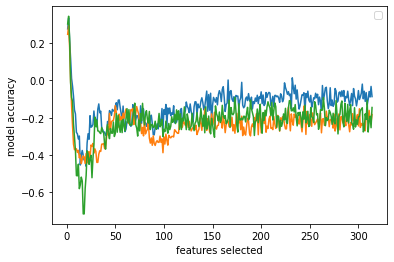

In [9]:
plt.ylabel('model accuracy')
plt.xlabel('features selected')
plt.plot(range(1, len(selector.grid_scores_)+1), selector.grid_scores_)
plt.legend()
plt.show() 

We see that model accuracy can be approximated and easily peaked at less than half the features. These are explored below

In [10]:
# printing the top 10 binary categories predicting salary
print(X_all_OH.columns[selector.ranking_ < 10])

Index(['YearsCode', 'YearsCodePro', 'WorkExp', 'LearnCode_JobTraining',
       'LearnCodeOnline_StackOverflow', 'LanguageHaveWorkedWith_SQL',
       'WebframeHaveWorkedWith_React_js',
       'OfficeStackAsyncHaveWorkedWith_Confluence',
       'OpSysProfessional use_Windows', 'Country_USA'],
      dtype='object')


In [11]:
X_top_10_OH = X_all_OH.loc[:, X_all_OH.columns[selector.ranking_ < 10]]
X_top_10_OH.shape

(8392, 10)

In [12]:
for name, estimator in regressors.items():
    train_err, test_err = train_test_eval(estimator(), X_top_10_OH, y, mean_squared_error, metric_args={'squared':False})
    print(f'***\n{name} train error: {train_err} kUSD/year, test error: {test_err} kUSD/year')

***
dummy means train error: 5330.408546282872 kUSD/year, test error: 73.82675788298933 kUSD/year
***
Decision Trees train error: 170.22025455147303 kUSD/year, test error: 90.76189337226381 kUSD/year
***
Random Forest train error: 679.8024363371749 kUSD/year, test error: 65.40816747228936 kUSD/year
***
Ada Boost train error: 3666.167290504283 kUSD/year, test error: 62.43011622470515 kUSD/year
***
Gradient Boost train error: 3125.884925912847 kUSD/year, test error: 59.501599287557895 kUSD/year
***
Histogram Gradient Boost train error: 2552.008694559351 kUSD/year, test error: 60.71177362201879 kUSD/year


## Using PCA for dimensionality reduction

In [13]:
pca = PCA(n_components=0.99) # retain 99% variance
X_pca = pca.fit(X_all_OH).transform(X_all_OH)
print(f'{X_pca.shape[-1]} features retain 99% of variance from {X_all_OH.shape[-1]} features of X_all_OH')

151 features retain 99% of variance from 314 features of X_all_OH


In [14]:
for name, estimator in regressors.items():
    train_err, test_err = train_test_eval(estimator(), X_pca, y, mean_squared_error, metric_args={'squared':False})
    print(f'***\n{name} train error: {train_err} kUSD/year, test error: {test_err} kUSD/year')

***
dummy means train error: 5330.408546282872 kUSD/year, test error: 73.82675788298933 kUSD/year
***
Decision Trees train error: 3.0081686951824086e-32 kUSD/year, test error: 90.84277211947524 kUSD/year
***
Random Forest train error: 527.559867742403 kUSD/year, test error: 63.269938567084864 kUSD/year
***
Ada Boost train error: 5100.596747936133 kUSD/year, test error: 75.43519139402602 kUSD/year
***
Gradient Boost train error: 2243.4596591028007 kUSD/year, test error: 60.672373787513706 kUSD/year
***
Histogram Gradient Boost train error: 512.9595080607368 kUSD/year, test error: 59.174588080792475 kUSD/year


## Viz of PCA top-2 components

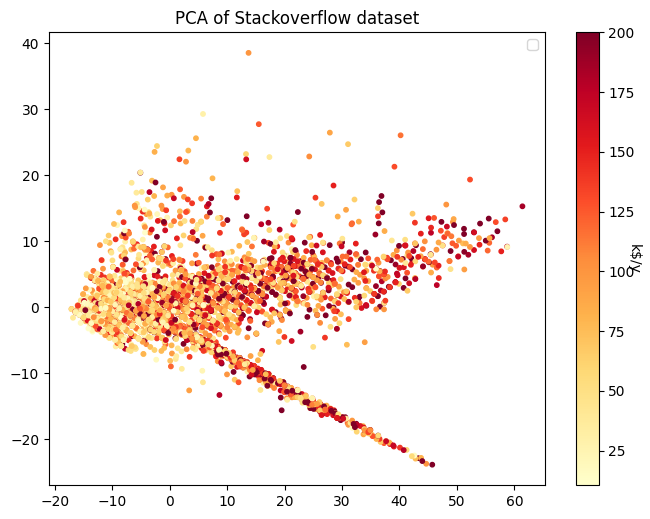

In [15]:
# Create a scatter plot of X_pca (2D). Colorbar shows the yearly compensation in k$.
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.clip(y, 0, 200), s=10, cmap='YlOrRd')
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Stackoverflow dataset")
plt.colorbar().set_label('k$/y', rotation=270, loc='center')

## Viz of t-SNE top 2 components

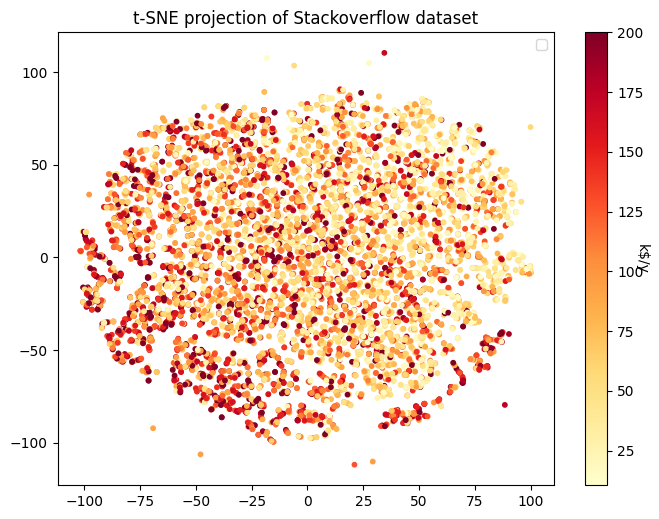

In [16]:
from sklearn.manifold import TSNE
# TSNE applied to StackOverflow Developer Survey Dataset
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_all_OH)

# Create a scatter plot of X_pca (2D). Colorbar shows the yearly compensation in k$.
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.clip(y, 0, 200), s=10, cmap='YlOrRd')
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("t-SNE projection of Stackoverflow dataset")
plt.colorbar().set_label('k$/y', rotation=270, loc='center')

## Using `CatBoostRegressor`

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_all_OH, y, test_size=0.4, random_state=0)
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=2000,
                          depth=5, 
                          learning_rate=0.04,
                          verbose=0,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,1)} kUSD/year, and for test {round(rmse_test,1)} kUSD/year")

NameError: name 'cat_cols_idx' is not defined

In [ ]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,1)} kUSD/year, and for test {round(rmse_bs_test,1)} kUSD/year")

<a id="section-explain"></a>
# Explanations with Shapley values

In [ ]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

In [ ]:
expected_values = ex.expected_value
print(f"Average expected compensation is {round(expected_values,1)} kUSD/year")
print(f"Average actual compensation is {round(np.mean(y_test),1)} kUSD/year")

In [ ]:
def show_shap(col):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,X_test.columns.tolist().index(col)]
    gain = 0
#    if df_infl.groupby(col).mean()['shap_'].sum() != 0:
        #print(df_infl.groupby(col).mean()['shap_'].sort_values(ascending=False))
    gain = df_infl.groupby(col).mean().loc[1, 'shap_']-df_infl.groupby(col).mean().loc[0, 'shap_']
    gain_std = ((df_infl.groupby(col).std().loc[1, 'shap_'])**2+(df_infl.groupby(col).std().loc[0, 'shap_'])**2)**0.5
#        print(round(gain, 2))
#        shap.dependence_plot(col, shap_values, X_test, interaction_index=None)
    return round(gain,3), round(gain_std,3)

In [ ]:

def show_variants(start_str='PlatformHaveWorkedWith'):
    col_list = []
    gain_list = []
    gain_std_list = []
    for col in X_test.columns:
        if col.startswith(start_str+'_'):
            try:
                gain, gain_std = show_shap(col)
                col_list.append(col.replace(start_str+'_',''))
                gain_list.append(gain)
                gain_std_list.append(gain_std)
            except:
                pass
    dd_dict = {'col': col_list, 'gain, kUSD/year': gain_list, 'gain_std': gain_std_list}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain, kUSD/year', ascending=False).set_index('col')
    plt.figure(figsize=(9,6))
    plt.errorbar(df_res.index, df_res['gain, kUSD/year'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.bar(x=df_res.index, height=df_res['gain, kUSD/year'])
    plt.title(f'SHAP values for {start_str}, yearly compensation')
    plt.ylabel('kUSD/year')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    return df_res

In [ ]:
show_variants('LearnCode')

In [ ]:
show_variants('LearnCodeOnline')

In [ ]:
show_variants('LearnCodeCoursesCert')

In [ ]:
show_variants('PlatformHaveWorkedWith')

In [ ]:
show_variants('LanguageHaveWorkedWith')

In [ ]:
show_variants('DatabaseHaveWorkedWith')

In [ ]:
show_variants('WebframeHaveWorkedWith')

In [ ]:
show_variants('MiscTechHaveWorkedWith')

In [ ]:
show_variants('ToolsTechHaveWorkedWith')

In [ ]:
show_variants('NEWCollabToolsHaveWorkedWith')

In [ ]:
show_variants('OfficeStackAsyncHaveWorkedWith')

In [ ]:
show_variants('OfficeStackSyncHaveWorkedWith')

In [ ]:
show_variants('OpSysProfessional use')